In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [147]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from collections import OrderedDict

from torch.autograd import variable

import shutil

In [153]:
img_dt='/content/drive/MyDrive/Colab Notebooks/DC_GAN/data'


In [154]:
def transformation(pth):
  data_transforms= transforms.Compose(
    [
        transforms.Resize((512,512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  dt=datasets.ImageFolder(pth,transform=data_transforms)

  return dt
  

In [155]:
train_data=transformation(img_dt)


In [156]:
def data_load(dt,batch_size,num_workers):
  x=torch.utils.data.DataLoader(dt, batch_size=batch_size, num_workers=num_workers, shuffle=True)

  return x

In [157]:
train_loader=data_load(train_data, batch_size=64, num_workers=2)

In [158]:
import torch.nn.functional as F

'''
Building the GAN
GAN is made up of a Discriminator and Generator
'''
#building the conv layer

def conv_layer(cin, cout,kernel_size,stride=2,padding=1,batch_norm=True):
  '''Creating a convolutional layer with batch norm(optional)'''
  layers=[]
  conv=nn.Conv2d(cin, cout,
                 kernel_size,stride, padding, bias=False)
  #appen layers

  layers.append(conv)

  if batch_norm:
    layers.append(nn.BatchNorm2d(cout))
  
  return nn.Sequential(*layers)




class Discriminator(nn.Module):

  def __init__(self, conv_dim=32):
    super(Discriminator,self).__init__()

    ''' Defining the convolution layers of the discrimator'''
    self.conv_dim=conv_dim

    self.conv1=conv_layer(3,conv_dim,4,batch_norm=False)
    self.conv2=conv_layer(conv_dim, conv_dim*2,4, batch_norm=True)
    self.conv3=conv_layer(conv_dim*2,conv_dim*4,4)
   

    self.fc=nn.Linear(conv_dim*4*4*4,1)


  def forward(self,x):
    output=F.leaky_relu(self.conv1(x),0.2)
    output=F.leaky_relu(self.conv2(output),0.2)
    output=F.leaky_relu(self.conv3(output),0.2)

    #flatten outputs
    output=output.view(-1,self.conv_dim*4*4*4)

    output=self.fc(output)
    #output=F.sigmoid(self.conv4(output))

    return output





In [159]:
'''Building the deconv func'''

def deconv_layer(cin, cout,kernel_size,stride=2,padding=1,batch_norm=True):
  '''Creating a transposed convolutional layer with batch norm(optional)'''
  layers=[]
  transpose_conv=nn.ConvTranspose2d(cin, cout,
                 kernel_size,stride, padding, bias=False)
  #append layers

  layers.append(transpose_conv)

  if batch_norm:
    layers.append(nn.BatchNorm2d(cout))
  
  return nn.Sequential(*layers)


In [160]:
'''Building the generator'''

class Generator(nn.Module):
  def __init__(self,z_in,conv_dim=32):
    super(Generator, self).__init__()
    self.conv_dim=conv_dim

    self.fc=nn.Linear(z_in,conv_dim*4*4*4)

    self.d_conv1=deconv_layer(conv_dim*4,conv_dim*2,4)
    self.d_conv2=deconv_layer(conv_dim*2, conv_dim,4)
    self.d_conv3=deconv_layer(conv_dim,3,4,batch_norm=True)
   


  def forward(self, x):
    #fully connected layer and reshaping
    output=self.fc(x)
    output=output.view(-1, self.conv_dim*4,4,4)

    #hidden conv transpose + relu

    output=F.relu(self.d_conv1(output))
    output=F.relu(self.d_conv2(output))
    

    #final layer +tanh activation func

    output=self.d_conv3(output)
    output=F.tanh(output)

    return output



In [161]:
'''Instantianting the whole network, setting hyperparams'''

conv_dim=32
z_size=100

discrim_net=Discriminator(conv_dim)
gen_net=Generator(z_in=z_size, conv_dim=conv_dim)

In [162]:
#printing discriminator net

print(discrim_net)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [163]:
#printing generator net

print(gen_net)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (d_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (d_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (d_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [164]:
'''Defining the loss, generator loss and discriminator loss'''
if torch.cuda.is_available():
  gen_net.cuda()
  discrim_net.cuda()
  print("Training on GPU")

else:
  print(" Training on CPU")


def loss_real(D_out,smooth=False):
  batch_size=D_out.size(0)
  #label smoothing

  if smooth:
    #smoothing and real labels=0.9
    labels=torch.ones(batch_size)*0.9
  else:
    #real labels
    labels=torch.ones(batch_size)

  if torch.cuda.is_available():
    labels=labels.cuda()

  criterion=nn.BCEWithLogitsLoss()
  loss=criterion(D_out.squeeze(),labels)

  return loss



def loss_fake(D_out):
  batch_size=D_out.size(0)

  labels=torch.zeros(batch_size)
  labels=torch.zeros(batch_size)

  if torch.cuda.is_available():
    labels= labels.cuda()
  criterion=nn.BCEWithLogitsLoss()

  loss=criterion(D_out.squeeze(), labels)

  return loss


Training on GPU


In [165]:
#setting the optimmisers for both generator and discriminator

lr=0.0002
beta1=0.5
beta2=0.999

discrim_optim=optim.Adam(discrim_net.parameters(),lr,[beta1,beta2])
gen_optim=optim.Adam(gen_net.parameters(), lr, [beta1,beta2])


In [166]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [167]:
num_epochs=1000
#loss and generated, fake samples

samples=[]
losses=[]
print_every=300

sample_size=16
fixed_z=np.random.uniform(-1,1,size=(sample_size,z_size))
fixed_z=torch.from_numpy(fixed_z).float()

for epoch in range(num_epochs):
  for batch_i, (real_img, _) in enumerate(train_loader):
    batch_size=real_img.size(0)

    real_img=scale(real_img)
    #---------------------------
    #  Training the discriminator
    #---------------------------

    discrim_optim.zero_grad()
    #train with real img

    if torch.cuda.is_available():
      real_img=real_img.cuda()
    

    D_real=discrim_net(real_img)
    d_loss_real=loss_real(D_real) #calculate the discriminator loss on real images

    #training with fake images

    z=np.random.uniform(-1,1,size=(batch_size,z_size)) #generating fake images
    z=torch.from_numpy(z).float()

    if torch.cuda.is_available():
      z=z.cuda()
    fake_img=gen_net(z)

    #calculate dicriminator loss on fake images

    D_fake=discrim_net(fake_img)
    D_fake_loss=loss_fake(D_fake)

    # adding loss and perfom backprop

    d_loss=d_loss_real +D_fake_loss
    d_loss.backward()
    discrim_optim.step()


    #---------------------------------
    # Training the Generator
    #--------------------------------

    gen_optim.zero_grad()

    #Training generator with fake images and flipped labels

    z=np.random.uniform(-1,1,size=(batch_size, z_size))
    z=torch.from_numpy(z).float()

    if torch.cuda.is_available():
      z=z.cuda()

    fake_img=gen_net(z)

    #calculate the discriminator loss on fake images using flipped labels

    D_fake=discrim_net(fake_img)
    g_loss=loss_real(D_fake) #using real loss to flip labels

    g_loss.backward()
    gen_optim.step()

    #printing some loss stats

    if batch_i % print_every==0:
      losses.append((d_loss.item(),g_loss.item()))
      print(
          'Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item())
      )

    
  '''Generating and saving sample images after each epoch'''

  gen_net.eval() #generating sample images

  if torch.cuda.is_available():
    fixed_z=fixed_z.cuda()
  samples_z=gen_net(fixed_z)
  samples.append(samples_z)
  gen_net.train()



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/ 1000] | d_loss: 1.4567 | g_loss: 0.8600
Epoch [    2/ 1000] | d_loss: 0.9311 | g_loss: 1.5312
Epoch [    3/ 1000] | d_loss: 0.7700 | g_loss: 1.7923
Epoch [    4/ 1000] | d_loss: 0.6577 | g_loss: 2.1199
Epoch [    5/ 1000] | d_loss: 0.5851 | g_loss: 2.4255
Epoch [    6/ 1000] | d_loss: 0.5375 | g_loss: 2.7221
Epoch [    7/ 1000] | d_loss: 0.4866 | g_loss: 2.9182
Epoch [    8/ 1000] | d_loss: 0.4501 | g_loss: 3.1065
Epoch [    9/ 1000] | d_loss: 0.4098 | g_loss: 3.2883
Epoch [   10/ 1000] | d_loss: 0.3822 | g_loss: 3.3857
Epoch [   11/ 1000] | d_loss: 0.3410 | g_loss: 3.4586
Epoch [   12/ 1000] | d_loss: 0.3075 | g_loss: 3.5154
Epoch [   13/ 1000] | d_loss: 0.2899 | g_loss: 3.6707
Epoch [   14/ 1000] | d_loss: 0.2508 | g_loss: 3.7929
Epoch [   15/ 1000] | d_loss: 0.2456 | g_loss: 3.9642
Epoch [   16/ 1000] | d_loss: 0.1824 | g_loss: 4.0487
Epoch [   17/ 1000] | d_loss: 0.1843 | g_loss: 4.1623
Epoch [   18/ 1000] | d_loss: 0.1542 | g_loss: 4.2234
Epoch [   19/ 1000] | d_loss

In [168]:
#saving generated sample images as pickle file
import pickle as pkl
with open('train_samples.pkl','wb') as f:
  pkl.dump(samples,f)

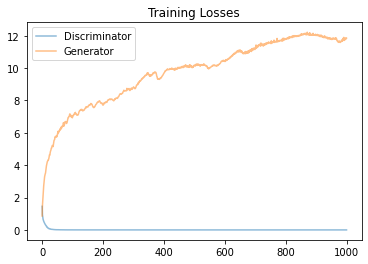

In [169]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [170]:
#viewing samples of generated images

def sample_view(epoch, samples):
  fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((32,32,3)))

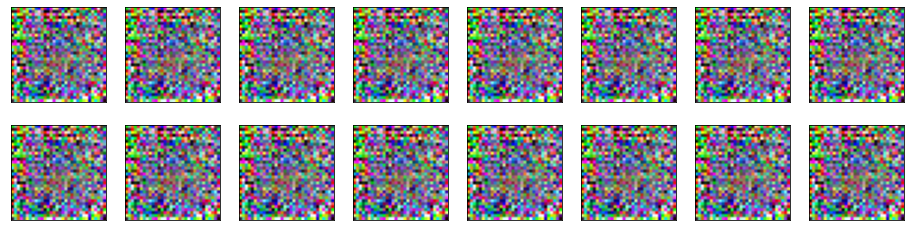

In [171]:
_=sample_view(-1,samples)